## Create Extreme Year Experiments

Notebook 1/X

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

As climate change continues to impact our world, it becomes increasingly important to understand the robustness of our best (Long Short-Term Memory networks), and most commonly used (conceptual models like SAC-SMA), hydrological models. To begin characterizing model robustness we need to design experiments that simulate a changing climate within the models, or simulated climate nonstationarity. This notebook creates 1) pickled dictionaries of per-basin train and test dates to be included in the NH configuration files and 2) configuration files, both in NH's configuration format, for the NH LSTM model as well as the SAC-SMA model.

Outputs from this notebook are all pickled dictionaries and include 1) climate indices (optional), 2) train & test dates, and 3) configuration files (.yml) for NH & SAC-SMA.

### Import Libraries

In [1]:
#Automatically reload modules; ensures most recent versions
%load_ext autoreload
%autoreload 2

In [2]:
#Import Python libraries
import os
import sys
import copy
import random
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import statistics as stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Define Parameters

This is the only section you will need to edit code in.

##### Most Important Experiment Parameters

First, we define which models we want to create dynamic indices (the default being dynamic mean precipitation and dynamic mean aridity), train & test dates, and configurations for. Options for each variable are listed (ex.- 'x' or 'y') in the comments above the variables. The "inputs" variable refers to how climate indexes will be input into the model, either statically or dynamically. The "exp_type" variable, short for "experiment type", refers to the type of data the model will be trained/tested on. Will the resulting train/test sets consist of years chosen based on their extreme climate index value (simulating climate nonstationarity) or will they be chosen randomly (for a benchmark model)? The "forcing" variable refers to which CAMELS forcing source the model will use (note: the National Water Model (NWM) uses NLDAS). Finally, the "years" variable refers to the range of years we want to pull the train/test set years from: we can use all years avaliable in CAMELS (1980-2014) _or_ we can clip the index to only include years also avalible for the National Water Model (1995-2014). This option is provided so that the NWM can be used as a benchmark.

In [3]:
#########################################################################################

#Create SAC-SMA configuration files? 
sacsma = False
#Create NH configuration files?
nh = True

#Climate index input type: 'static' (Addor et al., 2017) or 'dynamic'?
# NOTE: SAC-SMA does not accept static or dynamic climate inputs
inputs = 'dynamic'

#Experiment type: train/test on 'extreme' or 'random' years?
exp_type = 'random'

#Forcing source: CAMELS forcing data source? (5 options: 'daymet', 'nldas'(_extended'), 'maurer'(_extended'))
forcing = 'daymet'

#Range of years: train/test sets sourced from 'all' years or only 'nwm' years?
years = 'all'

#########################################################################################

##### Additional Experiment Parameters

The remaining parameters are less apt to change (in my experience). First we need to make some decisions about the dynamic climate indexes since they are used to determine the train/test sets for the models; extreme or random, static or dynamic alike. Will the dynamic climate indexes need to calculated and saved or will that file already exist (calculate_indexes)? If the exp_type == 'extreme', which climate indexes do we want to create extreme train/test sets for (default is mean precipitation (p_mean) and aridity)? If exp_type == 'random', how many random experiments, each with a unique random train/test set, do we want to create (num_random_experiments; default is 10)?

Finally, we need to decide the amount of years we want in our train/test sets (default for both is 5) and how many (default is 10), and which (default starts at seed 100) random seeds we want to use. 

In [4]:
#########################################################################################

#Do the dynamic climate indexes need to be calculated? If True and file exists, will be overwritten
calculate_indices = False

#IF EXP_TYPE == 'EXTREME': Which indexes do we want to create extreme train/test sets for?
use_climate_indexes = ['p_mean_dyn', 'aridity_dyn']

#IF EXP_TYPE == 'random': How many random train/test sets do we want to create?
num_random_experiments = 10

#########################################################################################

#Specify number of years to be used in train and test sets
n_train_years = 5
n_test_years = 5

#Specify number of ensemble members and first random seed value (increases by 1 for n num_seeds)
num_seeds = 10
first_seed = 100

#########################################################################################

##### Notebook Configurations

To be safe, we need to explicitly define the functionality of this notebook; we don't want to accidentally overwrite something important, or maybe we want to overwrite the dates but not the configs, etc. Here we can explicitly decide if we want to overwrite the config files, if they already exist, and/or if we want to overwrite the date_files. If exp_type == 'random', be careful with setting overwrite_dates to True; some benchmark experiments benefit from consistent random train/test sets. Also, if you want any of the resulting plots to be interactive in this notebook, now's your time to define interactive_plots.

In [5]:
#########################################################################################

#Overwrite existing configuration files?
overwrite_configs = False

#Overwrite existing train/test date files? TYPICALLY FALSE FOR RANDOM EXPERIMENTS
overwrite_dates = False

#Define if in-notebook plots are interactive (typically not needed)
interactive_plots = False

#########################################################################################

##### Paths

The first 5 paths in the cell below need to be replaced with your own filepaths and filenames. The remaining paths, assuming the repository maintains its original structure, do not have to be replaced since they are named dynamically with the values of the variables defined above.

In [6]:
#########################################################################################

#Path to working directory (where this notebook is)
working_dir = Path('/home/lmqualls/kratzert/climate/nonstationarity') #Fix

#Path to "configs" directory (../configs)
config_dir = working_dir / 'configs' #Fix

#Filepath (including filename) to (load or save a) dynamic climate indexes pickle file
climate_indices_file = config_dir / f'additional_features/dyn_climate_indices_{forcing}_531basins_365lookback.p'

#########################################################################################

#If you use this repository's directory structure, you not need to edit the paths below, but just in case...

#Path to "run_configs" directory (../run_configs)
run_configs_dir = config_dir / 'run_configs'

#Path to folder to save train/test sets to
dates_dir = working_dir / 'extreme_year_dates'

#Path to NeuralHydrology codebase ('../neuralhydrology/neuralhydrology')
nh_dir = Path('/home/lmqualls/kratzert/climate/neuralhydrology/neuralhydrology') #Fix

#Dynamic path to save the NH configuration files to (based on defined variable values)
nh_configs_path = run_configs_dir / f'nh/{inputs}/{exp_type}/{forcing}/{years}'

#Dynamic path to save the SAC-SMA configuration files to (based on defined variable values)
sacsma_configs_path = run_configs_dir / f'sacsma/{inputs}/{exp_type}/{forcing}/{years}'

#Path to dummy config file (based on defined input type)
dummy_config_file = config_dir / 'dummy_configs' / f'climate_experiment_{inputs}_dummy.yml' 

#########################################################################################

**You should not have to edit anything below this cell.**

I want to address "holdout_types", as this can be a confusing concept (this was Grey Nearing's naming scheme, not mine). Note that these _only_ need to be defined for extreme experiments. Holdout types are the "type" of years that will be excluded, or _held out_, of the **training** set and ultimately used in the **test** set. For example, if we want to simulate an increasingly arid climate, represented by the dynamic mean precipitation index (p_mean), we want to **train on high** average p_mean years and **test on low** average p_mean years; this experiment would be called **p_mean_dyn_low**, because years with **low** average p_mean years are excluded from the training set and used in the **test** set.

The cell below orients the notebook based on the parameters specifed above.

In [7]:
#########################################################################################

#Point to NeuralHydrology codebase
sys.path.append(str(nh_dir))

#Import NeuralHydrology functions
from utils import config
from datautils.utils import load_basin_file
# from datautils.climateindices import calculate_camels_us_dyn_climate_indices

# #########################################################################################

#Explicitly describe types of extremes
holdout_types = ['low', 'high']

#List the files currently in the dates_dir
date_files = os.listdir(dates_dir)

#Create list of seeds from seed information
seeds = list(range(first_seed, first_seed + num_seeds))

#########################################################################################

#if exp_type == 'random'... 
if exp_type == 'random':
    
    #Experiment names will consist of representative integers for num_random_experiments
    experiments = list(range(num_random_experiments))

#if exp_type == 'random'... 
if exp_type == 'extreme':
    
    #An experiment will be made for...
    experiments = []
    
    #...each climate index and...
    for index in use_climate_indexes:
        
        #...each holdout_type
        for htype in holdout_types:
            
            experiment = f'{index}_{htype}'
            experiments.append(experiment)
    
    #Personally, I like having my experiments in alphabetical order
    experiments = list(np.sort(experiments))
    
#########################################################################################

#If forcing == 'nldas_extended'...
if forcing == 'nldas_extended':
    
    #The forcing data column names for NH (ndyns) and SAC-SMA (sdyns) are as follows
    ndyns = ['PRCP(mm/day)','SRAD(W/m2)','Tmax(C)','Tmin(C)','Vp(Pa)']
    sdyns = ['PRCP(mm/day)','SRAD(W/m2)','Tmax(C)','Tmin(C)','Vp(Pa)']
    
#If forcing == 'daymet'...
if forcing == 'daymet':
    
    #The forcing data column names for NH (ndyns) and SAC-SMA (sdyns) are as follows
    ndyns = ['prcp(mm/day)','srad(W/m2)','tmax(C)','tmin(C)','vp(Pa)']
    sdyns = ['prcp(mm/day)','srad(W/m2)','tmax(C)','tmin(C)','vp(Pa)']
    
#########################################################################################

#Make plots interactive or inline based on interactive_plots variable
if interactive_plots:
    
    %matplotlib notebook
    %matplotlib notebook
    
else:
    
    %matplotlib inline
    
#########################################################################################

### Explicit Warnings

Just to make sure we understand the magnitude of running this notebook, some warnings are printed to remind you of existing experiments and your current overwrite variables.

In [8]:
#If we are creating configurations for NH...
if nh:
    
    #Check if the filepath to the configs already exists, and if it does...
    if os.path.isdir(nh_configs_path) == True:
        
        #Warn us!
        print('\033[91m'+'\033[1m'+'NH exeriments already exist.')

#If we are creating configurations for SAC-SMA...
if sacsma:
    
    #Check if the filepath to the configs already exists, and if it does...
    if os.path.isdir(sacsma_configs_path) == True:
        
        #Warn us!
        print('\033[91m'+'\033[1m'+'SAC-SMA exeriments already exist.')

#If we said we wanted to overwrite config files, that's fine, but...
if overwrite_configs == True:
    
    #Warn us!
    print('\nConfiguration files will be overwritten.')
    
#If we said we wanted to overwrite config files, that's fine, but...
if overwrite_dates == True:
    
    #Warn us!
    print('Dates files will be overwritten.')

### Load and/or Create Data Files

Let's get started.

As a reminder, the dummy_config_files is a representative config file with some dummy parameters and some pre-set parameters. To change the pre-set parameters, you need to edit the dummy config files.

Now we want to get a list of basins that the configuration files will be using data from. The default basin list is the 531_basin_list.txt which uses 531, out of 671, CAMELS basins. The remaining basins were excluded for a variety of reasons (Newman et al., 2017).

In [9]:
#Load in dummy configuration file
cfg = config.Config(dummy_config_file)

#Extract file of list of basin from the dummy config
basins = load_basin_file(cfg.train_basin_file)

#Print the number of basins the model will using data from
print(f'There are {len(basins)} basins.')

There are 531 basins.


Next we utilize the calculate_indices variable we defined above to either calculate or load the dynamic climate index data. If True, this loop calculates the dynamic climate indices using the forcing source defined above. If False, we load the avaliable pickled climate_indices_file and take note of the first timestep.

In [10]:
#If calculate_indices == True...
if calculate_indices:
    
    #Make sure the file doesn't already exist
    if not os.path.exists(climate_indices_file):
    
        #Calculate dynamic climate indices from CAMELS forcing data
        climate_indices = calculate_camels_us_dyn_climate_indices(data_dir=cfg.data_dir, 
                                                           basins=basins, 
                                                           window_length=cfg.seq_length,
                                                           forcings=f'{forcing}')

        #Save climate_indices to the specified file path and name
        with open(climate_indices_file,'wb') as f:
            pkl.dump(climate_indices, f)

#If calculate_indices == False...
else:

    #Load pickled dynamic climate indices file
    with open(climate_indices_file, 'rb') as f:
        climate_indices = pkl.load(f)
        
#If we are creating experiments for only the NWM years...
if years == 'nwm': 
    
    #Define range of NWM years
    nwm_dates = pd.date_range('1995-10-01','2014-12-30')
    
    #And for every basin...
    for basin in basins:
        
        #Trim the datetime index to only include data within that range
        climate_indices[basin] = climate_indices[basin].loc[nwm_dates]

#Check beginning time step
print("Climate indexes beginning at",climate_indices[basins[0]].index[0])

Climate indexes beginning at 1980-01-01 00:00:00


Just to make sure that the basins from the configuration file match the basins avaliable in the climate_indices file, we want to run it through an assertion.

In [11]:
#Double check that basins in the climate index match the basin set from the dummy config
assert len(list(climate_indices.keys())) == len(basins)

We can now take a peek at an example climate index for an example basin.

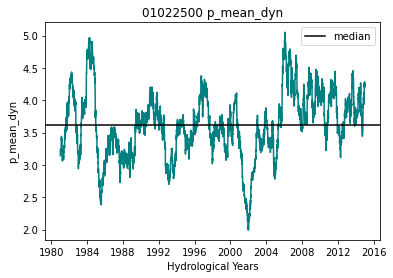

In [12]:
#Plot an example climate index for an example basin
plt.plot(climate_indices[basins[0]][use_climate_indexes[0]],c='teal')
plt.axhline(y=np.nanmedian(climate_indices[basins[0]][use_climate_indexes[0]]),color='k',label='median')
plt.legend()
plt.xlabel('Hydrological Years')
plt.ylabel(climate_indices[basins[0]][use_climate_indexes[0]].name)
plt.title(f'{basins[0]} {climate_indices[basins[0]][use_climate_indexes[0]].name}')
plt.show()

In [13]:
#If interactive plots enabled, must explicitly close plot
plt.close()

### Create Train/Test Sets

There are several steps in creating the train/test splits for the extreme/climate experiments: 1) define the train/test split function, 2) create the train/test sets using that function, and 3) saving the train/test sets as pickled dictionaries in the dates_dir (constituting the first external save of this notebook). But first, for fun, let's visualize how we create the train/test sets.

##### Visualization

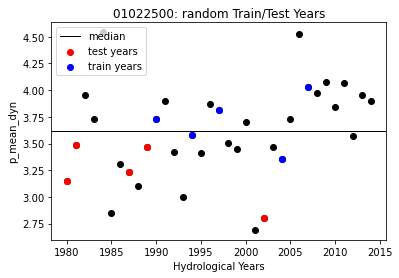

In [14]:
#Create a dataframe of an example basin for an example index and sort based on index value
ci_srt = climate_indices[basins[0]].dropna(0).sort_values(climate_indices[basins[0]].columns[0])

#Create 'year' column by extracting the years from the dataframe's datetime index
ci_srt['year'] = ci_srt.index.year
#Extract the year column
a = ci_srt.pop('year')
#Re-insert the 'year column into the first column position'
ci_srt.insert(value=a,column='year',loc=0)

#Create a list of hydro years, sorted temporally
xs = [int(x) for x in list(ci_srt.groupby('year').mean().index)]
#Create a list of mean climate index values, sorted temporally
ys = list(ci_srt.groupby('year').mean()[climate_indices[basins[0]].columns[0]])

#Create a list of sorted years, sorted by mean climate index values
sorted_years = list(ci_srt.groupby('year').mean().sort_values(climate_indices[basins[0]].columns[0]).index)  
    
#If we are creating extreme train/test sets...
if exp_type == 'extreme':

    #Create a list of sorted mean climate index values, sorted by mean climate index value
    sorted_ys = list(ci_srt.groupby('year').mean().sort_values(climate_indices[basins[0]].columns[0])[climate_indices[basins[0]].columns[0]])

    #Get a list of train years (one extreme)
    train_years = sorted_years[:5]
    #Get a list of train years' climate index values
    train_ys = sorted_ys[:5]
    #Get a list of test years (opposite extreme)
    test_years = sorted_years[-5:]
    #Get a list of test years' climate index values
    test_ys = sorted_ys[-5:]
    
if exp_type == 'random':
    
    #Zip sorted_years and ys together to maintain year, value relationship during shuffle
    temp = list(zip(sorted_years,ys))
    #Shuffle them
    np.random.shuffle(temp)
    #Unzip them
    random_years, random_ys = zip(*temp)
    
    #Get a list of train years
    train_years = random_years[:5]
    #Get a list of train years' climate index values
    train_ys = random_ys[:5]
    #Get a list of test years
    test_years = random_years[-5:]
    #Get a list of test years' climate index values
    test_ys = random_ys[-5:]

#Plot years and their corresponding climate index values
plt.scatter(xs,ys,color='k')
#Counters to limit setting labels once for each set
itrain = 0
itest = 0
#For every x,y pair in xs (years) and ys (values)...
for x,y in zip(xs,ys):
    #If y (value) is in train_ys...
    if y in train_ys:
        #Add 1 to itrain
        itrain = itrain + 1
        #And if itrain is equal to 1...
        if itrain == 1:
            #Plot year and value as blue point and label
            plt.scatter(x,y,color='blue',label='train years')
        #If itrain is not equal to 1...
        else:
            #Plot year and value as blue point
            plt.scatter(x,y,color='blue')
    #Or if y (value) is in test_years...
    if y in test_ys:
        #Add 1 to itest
        itest = itest + 1
        #And if itest is equal to 1...
        if itest == 1:
            #Plot year and value as red point and label
            plt.scatter(x,y,color='red',label='test years')
        #If itest is not equal to one...
        else:
            #Plot year and value as red point
            plt.scatter(x,y,color='red')

#Draw line of median climate value
plt.axhline(y=np.mean(climate_indices[basins[0]][climate_indices[basins[0]].columns[0]]), color='k',lw=1,label='median')

#Set x-axis label
plt.xlabel('Hydrological Years')
#Set title
plt.title(f'{basins[0]}: {exp_type} Train/Test Years')
# plt.title(f'{basins[0]}: Random Train/Test Years')

#Set x-axis tick interval
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
#Set y-axis label
plt.ylabel(f'{climate_indices[basins[0]].columns[0]}')

# plt.ylabel(f'Mean Precipitation (mm/day)')

plt.legend(loc=2)
plt.show()

##### Define split function

Here we create a function that orders data depending on the holdout type ("high" reverses the order of the argsorted list initialized later on), grabs the first n years for the test set and last n years for train set. It is important to understand this function, as it is the main decider for these climate experiments.

In [15]:
#Define a function that splits train and test years based on climate values
def train_test_split(idx, holdout, n_train, n_test):

    #If the holdout type is high, reverse the argsort so that high index values are the test set (as seen below)
    if holdout == 'high':
        idx.reverse()
        
    #Grab the first few years as the test set
    test = idx[:n_test]
    
    #Remove anything within sequence length of these years
    for t in test:
        try:
            idx.remove(t)
        except: 
            pass
        try:
            idx.remove(t+1)
        except: 
            pass
        try:
            idx.remove(t-1)
        except: 
            pass
    
    #Grab last few years as the train set
    train = idx[-n_train:] 
    
    #Return test and train sets
    return test, train

##### Create train/test sets

Unfortunately, the SAC-SMA and NH libraries work with dictionaries of conflicting key-orders. SAC-SMA is designed to read dictionaries with the format sacsma['start/end_dates'][basin] and NH is designed to read dictionaries with the format nh[basin]['start/end_dates']. This is accounted for in the following cells.

In [16]:
#If we are creating experiments for either of the models...
if nh or sacsma:
    
    #Initialize empty train/test dictionaries
    test_dates = {}
    train_dates = {}

    #For n experiments...
    for experiment in tqdm(experiments):
        
        #If we are creating extreme train/test sets
        if exp_type == 'extreme':
        
            #Experiment name is split from "_dyn" and rejoin (in case we are creating a static experiment)
            experiment = "".join(experiment.split("_dyn"))

        #Initialize experiment dictionary level
        test_dates[experiment] = {}
        train_dates[experiment] = {}

        #And for every basin...
        for b, basin in enumerate(basins):
            basin = str(basin)

        #Initialize train/test dictionary levels
            test_dates[experiment][basin] = {}
            test_dates[experiment][basin] = {}
            train_dates[experiment][basin] = {}
            train_dates[experiment][basin] = {}

            #Retrieve the dates from the index of a basin's climate indices dataframe
            dates = climate_indices[basin].index

            #The following start/end dates correspond to hydrological years
            #Extract any dates that are the 1st day of the 10th month 
            start_dates = climate_indices[basin].loc[(dates.month == 10) & (dates.day == 1)].index
            #Extract any dates that are the 30th day of the 9th month
            end_dates = climate_indices[basin].loc[(dates.month == 9) & (dates.day == 30)].index

            #Exclude the first and last years
            start_dates = start_dates[1:-1]
            #Exclude first two years to ensure there is no incomplete data years
            end_dates = end_dates[2:]

            #If we are making random experiments...
            if exp_type == 'random':

                #Make a list of the start and end dates "zipped" together
                temp = list(zip(start_dates, end_dates))
                #Shuffle the start/end date pairs
                np.random.shuffle(temp)
                #Separate the pairs into start and end dates while keeping them in order
                sorted_start_dates, sorted_end_dates = zip(*temp)

                #Extract first 5 random start/end dates and store them for the corresponding experiment
                test_dates[experiment][basin]['start_dates'] = list(sorted_start_dates[:5])
                test_dates[experiment][basin]['end_dates'] = list(sorted_end_dates[:5])

                #Extract last 5 random start/end dates and store them for the corresponding experiment
                train_dates[experiment][basin]['start_dates'] = list(sorted_start_dates[-5:])
                train_dates[experiment][basin]['end_dates'] = list(sorted_end_dates[-5:])

            #If we are making extreme experiments...
            if exp_type == 'extreme':

                #Get index of all hydrological year end_dates and drop any dates that return a value of NaN
                indexes_end_years = climate_indices[basin].loc[end_dates][index].dropna()                

                #Initialize list of hydrological start date indexes
                indexes_start_years = []

                #For every end date of an extreme year...
                for ed in indexes_end_years.index:

                    #Add the date exactly 364 days before the corresponding end_date to the start_years list
                    indexes_start_years.append(ed + pd.to_timedelta(-364,unit='d'))

                #Extract the numerical index of the start dates
                indexes_start_years = climate_indices[basin].loc[indexes_start_years][index]

                #Sort end_year indexes according to their corresponding climate index value
                sorted_indexes_end_years = list(np.argsort(indexes_end_years.values))
                #Make train and test index using train_test_split function
                test_dex, train_dex = train_test_split(sorted_indexes_end_years, htype, n_train_years, n_test_years)

                #Store test start & end dates for the corresponding experiment using the test_dex
                test_dates[experiment][basin]['start_dates'] = list(np.sort(list(indexes_start_years.iloc[test_dex].index)))
                test_dates[experiment][basin]['end_dates'] = list(np.sort(list(indexes_end_years.iloc[test_dex].index)))

                #Store train start & end dates for the corresponding experiment using the train_dex
                train_dates[experiment][basin]['start_dates'] = list(np.sort(list(indexes_start_years.iloc[train_dex].index)))
                train_dates[experiment][basin]['end_dates'] = list(np.sort(list(indexes_end_years.iloc[train_dex].index)))

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
#If sacsma == True, we need to switch the order of the dictionary keys...
if sacsma:
    
    #Initialize sacsma train & test dictionaries
    sacsma_train_dates = {}
    sacsma_test_dates = {}
    
    #For every experiment...
    for experiment in list(train_dates.keys()):
        
        #Initialize an experiment level
        sacsma_train_dates[experiment] = {}
        sacsma_test_dates[experiment] = {}
        
        #For every start &end date...
        for date in list(train_dates[experiment][basin].keys()):
            
            #Initalize a date level
            sacsma_train_dates[experiment][date] = {}
            sacsma_test_dates[experiment][date] = {}
            
            #And for every basin...
            for basin in list(train_dates[experiment].keys()):
                
                #Input the dataframes made above into the sacsma train & test dictionaries
                sacsma_train_dates[experiment][date][basin] = train_dates[experiment][basin][date]
                sacsma_test_dates[experiment][date][basin] = test_dates[experiment][basin][date]

##### Save train/test sets

The train/test sets are saved as pickled dictionaries in the dates_dir defined above. Notice that these files are named dynamically and that the titles indicate the parameters of the experiment they are to be used in. The naming format for the train/test sets will be in the order of model, experiment type, train/test, years, and experiment name.

In [18]:
#For every experiment...
for e, experiment in enumerate(tqdm(train_dates.keys())):
    
    #If we are creating train/test sets for neuralhydology...
    if nh == True:

        #If the date file is NOT already in extreme_year_dates folder or if we want to overwrite that file...
        if not f'nh_{exp_type}_train_{years}_{experiment}.pkl' in date_files or overwrite_dates == True:

            #Define name of train/test file according to experiment parameters
            test_fname = Path(f'{dates_dir}/nh_{exp_type}_test_{years}_{experiment}.pkl')
            train_fname = Path(f'{dates_dir}/nh_{exp_type}_train_{years}_{experiment}.pkl')

            #Save test fi~le for an experiment at test_fname
            with open(test_fname, 'wb') as f:
                pkl.dump(test_dates[experiment], f)

            #Save train file for an experiment at train_fname
            with open(train_fname, 'wb') as f:
                pkl.dump(train_dates[experiment], f)
        
    #If we are creating train/test sets for SAC-SMA...
    if sacsma == True:

        #If the date file is NOT already in extreme_year_dates folder or if we want to overwrite that file...
        if not f'sacsma_{exp_type}_train_{years}_{experiment}.pkl' in date_files or overwrite_dates == True:

            #Define name of train/test file according to experiment parameters
            test_fname = Path(f'{dates_dir}/sacsma_{exp_type}_test_{years}_{experiment}.pkl')
            train_fname = Path(f'{dates_dir}/sacsma_{exp_type}_train_{years}_{experiment}.pkl')

            #Save test file for an experiment at test_fname
            with open(test_fname, 'wb') as f:
                pkl.dump(sacsma_test_dates[experiment], f)

            #Save train file for an experiment at train_fname
            with open(train_fname, 'wb') as f:
                pkl.dump(sacsma_train_dates[experiment], f)

  0%|          | 0/10 [00:00<?, ?it/s]

### Create Configuration Files

Now that the extreme/random train/test sets have been created and saved, we can actually CREATE the configuration files by editing the dummy configuration file and replacing dummy variables with the new, defined variables and save the configuration file to the into the run_config_dir defined above.

In [19]:
#If we are creating config files for neuralhydrology...
if nh:
    
    #If the path to the configuration files already exists or if we want to overwrite those configuration files...
    if not os.path.isdir(nh_configs_path) or overwrite_configs == True:
        
        #For every experiment...
        for e,experiment in enumerate(train_dates.keys()):

            #For every seed...
            for seed in seeds:

                #Read in dummy config file
                with open(dummy_config_file, 'r') as file :
                    filedata = file.read()

                #Change dummy variables...
                #Experiment name
                exp_name = f'nh_{inputs}_{exp_type}_{forcing}_{years}_{experiment}_{seed}'
                #Location of run directory
                run_dir = f'{working_dir}/runs/nh/{inputs}/{exp_type}/{forcing}/{years}'     


                #Dummy train dates file
                train_dates_fname = str(dates_dir / f'nh_{exp_type}_train_{years}_{experiment}.pkl')
                #Dummy test dates file
                test_dates_fname = str(dates_dir / f'nh_{exp_type}_test_{years}_{experiment}.pkl')

                #Update dummy parameters 
                filedata = filedata.replace('dummy_run', exp_name)
                filedata = filedata.replace('dummy_dir',run_dir)
                filedata = filedata.replace('dummy_train_dates_file', train_dates_fname)
                filedata = filedata.replace('dummy_test_dates_file', test_dates_fname)
                filedata = filedata.replace('dummy_seed', f'{seed}')
                filedata = filedata.replace('dummy_forcing', f'{forcing}')
                filedata = filedata.replace('- dummy_dyn',f'- {ndyns[0]}\n- {ndyns[1]}\n- {ndyns[2]}\n- {ndyns[3]}\n- {ndyns[4]}')

                #Write new config file to the pre-defined config_dir
                new_config_path = Path(f'{nh_configs_path}')
                new_config_file = new_config_path / f'{exp_name}.yml'

                #If the path already exists, write files to it
                if os.path.exists(new_config_path):
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)

                #If the path does not exist, create it and write files to it
                else:
                    os.makedirs(os.path.join(run_configs_dir,'nh',inputs,exp_type,forcing,years))
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)


In [20]:
#If we are creating config files for neuralhydrology...
if sacsma:
    
    #If the path to the configuration files already exists or if we want to overwrite those configuration files...
    if not os.path.isdir(sacsma_configs_path) or overwrite_configs == True:
    
        #For every experiment...
        for e,experiment in enumerate(train_dates.keys()):

            #For every seed...
            for seed in seeds:

                #Read in dummy config file
                with open(dummy_config_file, 'r') as file :
                    filedata = file.read()

                #Change dummy variables...
                #Experiment name
                exp_name = f'sacsma_{inputs}_{exp_type}_{forcing}_{years}_{experiment}_{seed}'
                #Location of run directory
                run_dir = f'{working_dir}/runs/sacsma/{inputs}/{exp_type}/{forcing}/{years}'  
                
                #Dummy train dates file
                train_dates_fname = str(dates_dir / f'sacsma_{exp_type}_train_{years}_{experiment}.pkl')
                #Dummy test dates file
                test_dates_fname = str(dates_dir / f'sacsma_{exp_type}_test_{years}_{experiment}.pkl')

                #Update dummy parameters 
                filedata = filedata.replace('dummy_run', exp_name)
                filedata = filedata.replace('dummy_dir',run_dir)
                filedata = filedata.replace('dummy_train_dates_file', train_dates_fname)
                filedata = filedata.replace('dummy_test_dates_file', test_dates_fname)
                filedata = filedata.replace('dummy_seed', f'{seed}')
                filedata = filedata.replace('dummy_forcing', f'{forcing}')
                filedata = filedata.replace('- dummy_dyn',f'- {sdyns[0]}\n- {sdyns[1]}\n- {sdyns[2]}\n- {sdyns[3]}\n- {sdyns[4]}')
                

                #Write new config file to the pre-defined config_dir
                new_config_path = Path(f'{sacsma_configs_path}')
                new_config_file = new_config_path / f'{exp_name}.yml'

                #If the path already exists, write files to it
                if os.path.exists(new_config_path):
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)
                        
                #If the path does not exist, create it and write files to it
                else:
                    os.makedirs(os.path.join(run_configs_dir,'sacsma',inputs,exp_type,forcing,years))
                    with open(new_config_file, 'w') as file:
                        file.write(filedata)


You should now have configuration files ready to be run.